已连接到 tensorflow_gpu (Python 3.10.14)

对于固定 hpS1 = 12.0000，求得：
  phiS1 = -0.0061
  hpS2  = 5.9816
  phiS2 = 0.0057
对于 hpS1 = 12.0000，总能量 f = 0.0981


<ipython-input-1-50796b0b035a>:245: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1, r1, R1, r2, R2, theta_p0, hp0, n))
<ipython-input-1-50796b0b035a>:245: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1, r1, R1, r2, R2, theta_p0, hp0, n))
c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Le

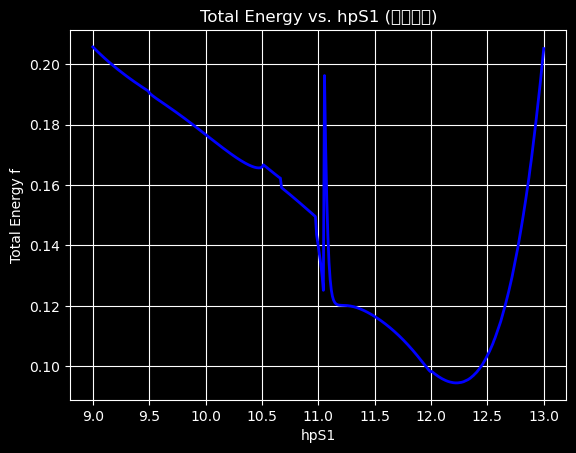

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# -------------------------------
# 常数与基本函数
# -------------------------------
miu0 = 4 * np.pi * 10**-7
mu0 = 4 * np.pi * 10**-7

# 计算矢量差
def rij(i, j, pts):
    return pts[j] - pts[i]

# 磁力计算
def Fmag(mi, mj, rijVec, miu0):
    mi = np.array(mi)
    mj = np.array(mj)
    rijVec = np.array(rijVec)
    norm_rij = np.linalg.norm(rijVec)
    dot_mi_rij = np.dot(mi, rijVec)
    dot_mj_rij = np.dot(mj, rijVec)
    dot_mi_mj = np.dot(mi, mj)
    term1 = dot_mi_rij * mj + dot_mj_rij * mi + dot_mi_mj * rijVec
    term2 = 5 * (dot_mi_rij * dot_mj_rij / norm_rij**2) * rijVec
    return -3 * miu0 / (4 * np.pi * norm_rij**5) * (term1 - term2)

def Tmag(mi, mj, rij, u0):
    norm_rij = np.linalg.norm(rij)
    #rij_normed = rij / norm_rij  # Unit vector in the direction of rij

    # Calculate the components
    term_1 = (np.dot(mi, rij) * mj[0] + np.dot(mj, rij) * mi[0] +
              np.dot(mi, mj) * rij[0] - 5 * (np.dot(mi, rij) * np.dot(mj, rij) / norm_rij**2) * rij[0])

    term_2 = (np.dot(mi, rij) * mj[1] + np.dot(mj, rij) * mi[1] +
              np.dot(mi, mj) * rij[1] - 5 * (np.dot(mi, rij) * np.dot(mj, rij) / norm_rij**2) * rij[1])

    result = -3 * u0 / (4 * np.pi * norm_rij**5) * (term_1 + term_2)
    return result


# 磁能量计算
def Emag(mi, mj, rijVec, miu0):
    norm_rij = np.linalg.norm(rijVec)
    dot_mi_mi = np.dot(mi, mi)
    dot_mi_rij = np.dot(mi, rijVec)
    dot_mj_rij = np.dot(mj, rijVec)
    return miu0 / (4 * np.pi) * (dot_mi_mi / norm_rij**3 - 3 * (dot_mi_rij * dot_mj_rij) / norm_rij**5)

# 弹簧几何量
def c(hs, phi, r, R, theta_p0):
    return np.sqrt(hs**2 + r**2 + R**2 - 2 * R * r * np.cos(theta_p0 + phi))

def d(hs, phi, r, R, theta_p0, n):
    return np.sqrt(hs**2 + r**2 + R**2 - 2 * R * r * np.cos(theta_p0 + phi + 2 * np.pi / n))

# 弹簧力
def Fcc(hs, phi, r, R, theta_p0, hp0, kc):
    return kc * (c(hs, phi, r, R, theta_p0) - c(hp0, 0, r, R, theta_p0))

def Fdd(hs, phi, r, R, theta_p0, hp0, kd, n):
    return kd * (d(hs, phi, r, R, theta_p0, n) - d(hp0, 0, r, R, theta_p0, n))

# 力和力矩的角度量
def Ac(hs, phi, r, R, theta_p0):
    return np.arctan(np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(theta_p0 + phi)) / hs)

def Ad(hs, phi, r,  R,theta_p0, n):
    return np.arctan(np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(theta_p0 + phi + (2*np.pi)/n)) / hs)

# Zeta 函数
def zeta(x, r, R):
    return np.sin(x) / np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(x))

# 总力函数（参数顺序：hs, phi, r, R, theta_p0, hp0, kc, kd, n）
def Ftotal(hs, phi, r, R, theta_p0, hp0, kc, kd, n):
    return n * (Fcc(hs, phi, r, R, theta_p0, hp0, kc) * np.cos(Ac(hs, phi, r,  R,theta_p0)) +
                Fdd(hs, phi, r, R, theta_p0, hp0, kd, n) * np.cos(Ad(hs, phi, r, R, theta_p0, n)))

# 总力矩函数（返回标量，实际取的是 z 分量）
def Ttotal(hs, phi, r, R, theta_p0, hp0, kc, kd, n):
    return n * R * r * (Fcc(hs, phi, r, R, theta_p0, hp0, kc) * np.sin(Ac(hs, phi, r, R, theta_p0)) *
                        zeta(theta_p0 + phi, r, R) +
                        Fdd(hs, phi, r, R, theta_p0, hp0, kd, n) * np.sin(Ad(hs, phi, r, R, theta_p0, n)) *
                        zeta(theta_p0 + phi + (2*np.pi)/n, r, R))

# 计算平面之间的夹角（暂未在后续使用）
def angleBetweenPlanes(pt1, pt2, pt3, pt4, pt5, pt6):
    n1 = np.cross(pt2 - pt1, pt3 - pt1)
    n2 = np.cross(pt5 - pt4, pt6 - pt4)
    return np.arccos(np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2)))

def angularEnergy(pt1, pt2, pt3, pt4, pt5, pt6, k_angle, theta0):
    theta = angleBetweenPlanes(pt1, pt2, pt3, pt4, pt5, pt6)
    return 0.5 * k_angle * (theta - theta0)**2

# -------------------------------
# Kresling 结构磁能量部分
# -------------------------------
def KreslingMagnetic(r, R, n, theta_p0, hp0, phi_p, hp):
    """
    返回三元组：(magEnergy, totalMagForce, magTorque)
    其中 magEnergy 为磁能量，
          totalMagForce 为所有磁力的矢量和，
          magTorque 此处暂取零（可根据需要扩展）。
    """
    Kd = 0.8 * 10 **8
    M = np.sqrt(2 * Kd / mu0)
    V = (10 / 1000) * np.pi * (8/ 100)**2
    magm = M * V
    # 磁矩方向交错排列，这里只取第一个分量用于计算
    mag = [(-1, 1) if i % 2 == 0 else (1, -1) for i in range(n)]
    
    # 两层点坐标
    Points1 = np.array([[R * np.cos(i / n * 2 * np.pi), R * np.sin(i / n * 2 * np.pi), 0] for i in range(n)])
    Points2 = np.array([[r * np.cos(i / n * 2 * np.pi + theta_p0 + phi_p),
                          r * np.sin(i / n * 2 * np.pi + theta_p0 + phi_p), hp] for i in range(n)])
    Points02 = np.array([[r * np.cos(i / n * 2 * np.pi + theta_p0 + phi_p),
                          r * np.sin(i / n * 2 * np.pi + theta_p0 + phi_p), hp0] for i in range(n)])
    Points = np.vstack([Points1, Points2])
    Points0 = np.vstack([Points1, Points02])
    
    theta01 = angleBetweenPlanes(Points0[1], Points0[2], Points0[n+1], Points0[n+1], Points0[n+2], Points0[2])
    theta02 = angleBetweenPlanes(Points0[n+1], Points0[n+2], Points0[2], Points0[2], Points0[3], Points0[n+2])
    k_angle=1
    angE = n * angularEnergy(Points[1], Points[2], Points[n+1], Points[n+1], Points[n+2], Points[2], k_angle, theta01)
    + n * angularEnergy(Points[n+1], Points[n+2], Points[2], Points[2], Points[3], Points[n+2], k_angle, theta02)
    
    magForce_list = []
    magToque_list = []
    magEnergy = 0
    # 注意：第二层磁矩采用 mag[j - n]
    for i in range(n):
        for j in range(n, 2 * n):
            mi = [0, 0, mag[i][0] * magm]
            mj = [0, 0, mag[j - n][0] * magm]
            force_ij = Fmag(mi, mj, rij(i, j, Points), mu0)
            magForce_list.append(force_ij)
            T_ij = Tmag(mi, mj, rij(i, j, Points), mu0)
            magToque_list.append(T_ij)
            magEnergy += Emag(mi, mj, rij(i, j, Points), mu0)
    totalMagForce = np.sum(np.array(magForce_list), axis=0) if magForce_list else np.array([0,0,0])
    totalMagToque = np.sum(np.array(magToque_list), axis=0) if magToque_list else np.array([0,0,0])
    return magEnergy, totalMagForce, totalMagToque, angE

# -------------------------------
# 总能量函数（弹簧势能 + 磁能量）
# -------------------------------
def totalU(hpS1, phiS1, r, R, theta_p0, hp0, n):
    kc = 1
    springEnergy = n / 2 * (kc * ((c(hpS1, phiS1, r, R, theta_p0) - c(hp0, 0, r, R, theta_p0))**2) +
                            kc * ((d(hpS1, phiS1, r, R, theta_p0, n) - d(hp0, 0, r, R, theta_p0, n))**2))
    result = KreslingMagnetic(r, R, n, theta_p0, hp0, phiS1, hpS1)
    magEnergy, angEnergy = result[0], result[3]

    return springEnergy + magEnergy + angEnergy

# -------------------------------
# 约束条件（共三个约束）
# -------------------------------
# 约束1：力平衡（取 z 分量），即
# Ftotal[hpS1, phiS1, 1, 2, theta_p0, 1, 1, 1, n] + (磁力的 z 分量) = 0
def g2(v, r1, R1, r2, R2, theta_p0, hp0, n):
    # v = [hpS1, phiS1, hpS2, phiS2]，但在“路径”求解中 hpS1 固定
    hpS1, phiS1, hpS2, phiS2 = v
    force1 = Ftotal(hpS1 - hpS2, phiS1 - phiS2, r1, R1, theta_p0, hp0, 1, 1, n)
    magForce1 = KreslingMagnetic(r1, R1, n, theta_p0, hp0, phiS1 - phiS2, hpS1 - hpS2)[1]
    force2 = Ftotal(hpS2, phiS2, r2, R2, theta_p0, hp0, 1, 1, n)
    magForce2 = KreslingMagnetic(r2, R2, n, theta_p0, hp0, phiS2, hpS2)[1]
    # 取 z 分量（索引 2）
    return (force1 + np.array(magForce1))[2] + (force2 + np.array(magForce2))[2]

# 约束2：力矩平衡（取 z 分量）
def g3(v, r1, R1, r2, R2, theta_p0, hp0, n):
    hpS1, phiS1, hpS2, phiS2 = v
    torque1 = Ttotal(hpS1 - hpS2, phiS1 - phiS2, r1, R1, theta_p0, hp0, 1, 1, n)
    magTorque1 = KreslingMagnetic(r1, R1, n, theta_p0, hp0, phiS1 - phiS2, hpS1 - hpS2)[2]
    torque2 = Ttotal(hpS2, phiS2, r2, R2, theta_p0, hp0, 1, 1, n)
    magTorque2 = KreslingMagnetic(r2, R2, n, theta_p0, hp0, phiS2, hpS2)[2]
    return torque1 + np.array(magTorque1) + torque2 + np.array(magTorque2)

# 约束3：能量函数对 hpS1 的偏导数为零
def g4(v, r, R, theta_p0, hp0, n):
    # 只依赖于 hpS1 和 phiS1（其中 hpS1 在路径中固定）
    return d_totalU_d_hpS1(v, r, R, theta_p0, hp0, n)

# 中心差分计算 totalU 对 hpS1 的偏导数
def d_totalU_d_hpS1(v, r, R, theta_p0, hp0, n, eps=1e-6):
    hpS1, phiS1, hpS2, phiS2 = v
    return (totalU(hpS1 + eps - hpS2, phiS1 - phiS2, r, R, theta_p0, hp0, n) - 
            totalU(hpS1 - eps - hpS2, phiS1 - phiS2, r, R, theta_p0, hp0, n)) / (2 * eps)

# -------------------------------
# 固定 hpS1 下求解其余三个未知数（phiS1, hpS2, phiS2）的方程组
# -------------------------------
def equations_with_fixed_hpS1(x, hpS1, r1, R1, r2, R2, theta_p0, hp0, n):
    # x = [phiS1, hpS2, phiS2]
    phiS1, hpS2, phiS2 = x
    # 构造完整变量向量 v，其中 hpS1 固定
    v = [hpS1, phiS1, hpS2, phiS2]
    eq1 = g2(v, r1, R1, r2, R2, theta_p0, hp0, n)
    eq2 = g3(v, r1, R1, r2, R2, theta_p0, hp0, n)
    eq3 = g4(v, r1, R1, theta_p0, hp0, n)
    return [eq1, eq2, eq3]

# -------------------------------
# 求解与绘图
# -------------------------------

# 示例参数
R1 = 4                # 外径
r1 = 2.5                # 内径
R2 = 5.5                # 外径
r2 = 4                # 内径
theta_p0 = np.pi/4   # 示例角度
hp0 = 6              # 示例高度
n = 6                # 节点数

# 先选择一个固定的 hpS1 值（例如 0.5），求解其余变量
hpS1_fixed = 12
initial_guess_fixed = [0, 6, 0]  # 对应 phiS1, hpS2, phiS2 的初值

sol_fixed = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1_fixed, r1, R1, r2, R2, theta_p0, hp0, n))
phiS1_sol, hpS2_sol, phiS2_sol = sol_fixed

print("对于固定 hpS1 = {:.4f}，求得：".format(hpS1_fixed))
print("  phiS1 = {:.4f}".format(phiS1_sol))
print("  hpS2  = {:.4f}".format(hpS2_sol))
print("  phiS2 = {:.4f}".format(phiS2_sol))

# 计算总能量
f_value = totalU(hpS1_fixed - hpS2_sol, phiS1_sol - phiS2_sol, r1, R1, theta_p0, hp0, n) + totalU(hpS2_sol, phiS2_sol, r2, R2, theta_p0, hp0, n)
print("对于 hpS1 = {:.4f}，总能量 f = {:.4f}".format(hpS1_fixed, f_value))

# -------------------------------
# 绘图：沿 hpS1 路径求解 (hpS1 为自由参数)
# -------------------------------
hpS1_values = np.linspace(9, 13, 400)  # 扫描 hpS1
energy_values = []
results = []  # 用于保存每个 hpS1 对应的求解结果

for hpS1 in hpS1_values:
    # 对每个 hpS1，求解其余三个未知数
    sol = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1, r1, R1, r2, R2, theta_p0, hp0, n))
    phiS1_sol, hpS2_sol, phiS2_sol = sol
    energy = totalU(hpS1 - hpS2_sol, phiS1_sol - phiS2_sol, r1, R1, theta_p0, hp0, n) + totalU(hpS2_sol, phiS2_sol, r2, R2, theta_p0, hp0, n)
    # 将 hpS1, phiS1, hpS2, phiS2 以及能量值存储到 results 中
    results.append([hpS1, phiS1_sol, hpS2_sol, phiS2_sol, energy])
    energy_values.append(energy)
    
# 转换为 NumPy 数组以便后续查看或处理
results = np.array(results)

plt.plot(hpS1_values, energy_values, 'b-', linewidth=2)
plt.xlabel('hpS1')
plt.ylabel('Total Energy f')
plt.title('Total Energy vs. hpS1 (路径问题)')
plt.grid(True)
plt.show()

In [ ]:
# %%
import numpy as np
import plotly.graph_objects as go
# 提取数据
x = results[:, 1]  # 第二列
y = results[:, 2]  # 第三列
z = results[:, 3]  # 第四列
t = results[:, 0]  # 第一列作为变化方向

# 计算切向量
dx = np.diff(x)
dy = np.diff(y)
dz = np.diff(z)

# 选择箭头的间隔，假设我们每隔10个点添加一个箭头
arrow_interval = 10

# 创建箭头数据
arrow_x = x[:-1:arrow_interval]
arrow_y = y[:-1:arrow_interval]
arrow_z = z[:-1:arrow_interval]
arrow_dx = dx[::arrow_interval]
arrow_dy = dy[::arrow_interval]
arrow_dz = dz[::arrow_interval]

# 归一化方向向量
magnitude = np.sqrt(arrow_dx**2 + arrow_dy**2 + arrow_dz**2)
arrow_dx /= magnitude
arrow_dy /= magnitude
arrow_dz /= magnitude


# 创建3D图形
fig = go.Figure()

# 绘制三维轨迹
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name='Trajectory', line=dict(color='blue')))

fig.add_trace(go.Cone(x=arrow_x, y=arrow_y, z=arrow_z, u=arrow_dx, v=arrow_dy, w=arrow_dz, 
                     colorscale='Viridis', showscale=False, sizemode="absolute", sizeref=1))


x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
z_min, z_max = np.min(z), np.max(z)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        zaxis=dict(range=[z_min, z_max]),
    ),
)


# 显示图像
fig.show()


对于固定 hpS1 = 12.0000，求得：
  phiS1 = -0.0015
  hpS2  = 5.8794
  phiS2 = 0.0547
对于 hpS1 = 12.0000，总能量 f = 0.1087


<ipython-input-4-2c95f6734913>:245: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

<ipython-input-4-2c95f6734913>:245: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from current font.

c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from current font.

c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from current font.

c:\Users\Lenovo\.conda\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 39064 (\N{CJK 

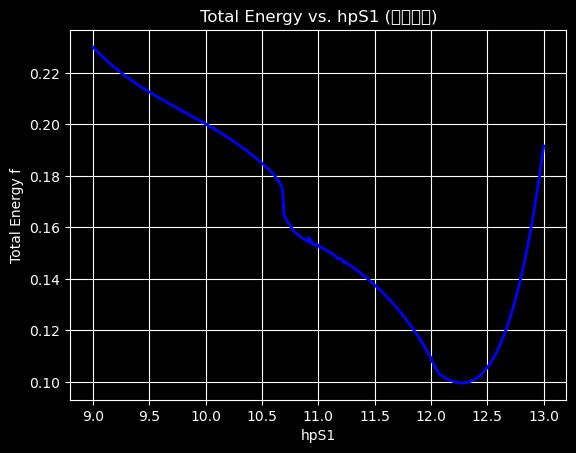

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# -------------------------------
# 常数与基本函数
# -------------------------------
miu0 = 4 * np.pi * 10**-7
mu0 = 4 * np.pi * 10**-7

# 计算矢量差
def rij(i, j, pts):
    return pts[j] - pts[i]

# 磁力计算
def Fmag(mi, mj, rijVec, miu0):
    mi = np.array(mi)
    mj = np.array(mj)
    rijVec = np.array(rijVec)
    norm_rij = np.linalg.norm(rijVec)
    dot_mi_rij = np.dot(mi, rijVec)
    dot_mj_rij = np.dot(mj, rijVec)
    dot_mi_mj = np.dot(mi, mj)
    term1 = dot_mi_rij * mj + dot_mj_rij * mi + dot_mi_mj * rijVec
    term2 = 5 * (dot_mi_rij * dot_mj_rij / norm_rij**2) * rijVec
    return -3 * miu0 / (4 * np.pi * norm_rij**5) * (term1 - term2)

def Tmag(mi, mj, rij, u0):
    norm_rij = np.linalg.norm(rij)
    #rij_normed = rij / norm_rij  # Unit vector in the direction of rij

    # Calculate the components
    term_1 = (np.dot(mi, rij) * mj[0] + np.dot(mj, rij) * mi[0] +
              np.dot(mi, mj) * rij[0] - 5 * (np.dot(mi, rij) * np.dot(mj, rij) / norm_rij**2) * rij[0])

    term_2 = (np.dot(mi, rij) * mj[1] + np.dot(mj, rij) * mi[1] +
              np.dot(mi, mj) * rij[1] - 5 * (np.dot(mi, rij) * np.dot(mj, rij) / norm_rij**2) * rij[1])

    result = -3 * u0 / (4 * np.pi * norm_rij**5) * (term_1 + term_2)
    return result


# 磁能量计算
def Emag(mi, mj, rijVec, miu0):
    norm_rij = np.linalg.norm(rijVec)
    dot_mi_mi = np.dot(mi, mi)
    dot_mi_rij = np.dot(mi, rijVec)
    dot_mj_rij = np.dot(mj, rijVec)
    return miu0 / (4 * np.pi) * (dot_mi_mi / norm_rij**3 - 3 * (dot_mi_rij * dot_mj_rij) / norm_rij**5)

# 弹簧几何量
def c(hs, phi, r, R, theta_p0):
    return np.sqrt(hs**2 + r**2 + R**2 - 2 * R * r * np.cos(theta_p0 + phi))

def d(hs, phi, r, R, theta_p0, n):
    return np.sqrt(hs**2 + r**2 + R**2 - 2 * R * r * np.cos(theta_p0 + phi + 2 * np.pi / n))

# 弹簧力
def Fcc(hs, phi, r, R, theta_p0, hp0, kc):
    return kc * (c(hs, phi, r, R, theta_p0) - c(hp0, 0, r, R, theta_p0))

def Fdd(hs, phi, r, R, theta_p0, hp0, kd, n):
    return kd * (d(hs, phi, r, R, theta_p0, n) - d(hp0, 0, r, R, theta_p0, n))

# 力和力矩的角度量
def Ac(hs, phi, r, R, theta_p0):
    return np.arctan(np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(theta_p0 + phi)) / hs)

def Ad(hs, phi, r,  R,theta_p0, n):
    return np.arctan(np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(theta_p0 + phi + (2*np.pi)/n)) / hs)

# Zeta 函数
def zeta(x, r, R):
    return np.sin(x) / np.sqrt(R**2 + r**2 - 2 * R * r * np.cos(x))

# 总力函数（参数顺序：hs, phi, r, R, theta_p0, hp0, kc, kd, n）
def Ftotal(hs, phi, r, R, theta_p0, hp0, kc, kd, n):
    return n * (Fcc(hs, phi, r, R, theta_p0, hp0, kc) * np.cos(Ac(hs, phi, r,  R,theta_p0)) +
                Fdd(hs, phi, r, R, theta_p0, hp0, kd, n) * np.cos(Ad(hs, phi, r, R, theta_p0, n)))

# 总力矩函数（返回标量，实际取的是 z 分量）
def Ttotal(hs, phi, r, R, theta_p0, hp0, kc, kd, n):
    return n * R * r * (Fcc(hs, phi, r, R, theta_p0, hp0, kc) * np.sin(Ac(hs, phi, r, R, theta_p0)) *
                        zeta(theta_p0 + phi, r, R) +
                        Fdd(hs, phi, r, R, theta_p0, hp0, kd, n) * np.sin(Ad(hs, phi, r, R, theta_p0, n)) *
                        zeta(theta_p0 + phi + (2*np.pi)/n, r, R))

# 计算平面之间的夹角（暂未在后续使用）
def angleBetweenPlanes(pt1, pt2, pt3, pt4, pt5, pt6):
    n1 = np.cross(pt2 - pt1, pt3 - pt1)
    n2 = np.cross(pt5 - pt4, pt6 - pt4)
    return np.arccos(np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2)))

def angularEnergy(pt1, pt2, pt3, pt4, pt5, pt6, k_angle, theta0):
    theta = angleBetweenPlanes(pt1, pt2, pt3, pt4, pt5, pt6)
    return 0.5 * k_angle * (theta - theta0)**2

# -------------------------------
# Kresling 结构磁能量部分
# -------------------------------
def KreslingMagnetic(r, R, n, theta_p0, hp0, phi_p, hp):
    """
    返回三元组：(magEnergy, totalMagForce, magTorque)
    其中 magEnergy 为磁能量，
          totalMagForce 为所有磁力的矢量和，
          magTorque 此处暂取零（可根据需要扩展）。
    """
    Kd = 0.8 * 10 **8
    M = np.sqrt(2 * Kd / mu0)
    V = (10 / 1000) * np.pi * (8/ 100)**2
    magm = M * V
    # 磁矩方向交错排列，这里只取第一个分量用于计算
    mag = [(-1, 1) if i % 2 == 0 else (1, -1) for i in range(n)]
    
    # 两层点坐标
    Points1 = np.array([[R * np.cos(i / n * 2 * np.pi), R * np.sin(i / n * 2 * np.pi), 0] for i in range(n)])
    Points2 = np.array([[r * np.cos(i / n * 2 * np.pi + theta_p0 + phi_p),
                          r * np.sin(i / n * 2 * np.pi + theta_p0 + phi_p), hp] for i in range(n)])
    Points02 = np.array([[r * np.cos(i / n * 2 * np.pi + theta_p0 + phi_p),
                          r * np.sin(i / n * 2 * np.pi + theta_p0 + phi_p), hp0] for i in range(n)])
    Points = np.vstack([Points1, Points2])
    Points0 = np.vstack([Points1, Points02])
    
    theta01 = angleBetweenPlanes(Points0[1], Points0[2], Points0[n+1], Points0[n+1], Points0[n+2], Points0[2])
    theta02 = angleBetweenPlanes(Points0[n+1], Points0[n+2], Points0[2], Points0[2], Points0[3], Points0[n+2])
    k_angle=1
    angE = n * angularEnergy(Points[1], Points[2], Points[n+1], Points[n+1], Points[n+2], Points[2], k_angle, theta01)
    + n * angularEnergy(Points[n+1], Points[n+2], Points[2], Points[2], Points[3], Points[n+2], k_angle, theta02)
    
    magForce_list = []
    magToque_list = []
    magEnergy = 0
    # 注意：第二层磁矩采用 mag[j - n]
    for i in range(n):
        for j in range(n, 2 * n):
            mi = [0, 0, mag[i][0] * magm]
            mj = [0, 0, mag[j - n][0] * magm]
            force_ij = Fmag(mi, mj, rij(i, j, Points), mu0)
            magForce_list.append(force_ij)
            T_ij = Tmag(mi, mj, rij(i, j, Points), mu0)
            magToque_list.append(T_ij)
            magEnergy += Emag(mi, mj, rij(i, j, Points), mu0)
    totalMagForce = np.sum(np.array(magForce_list), axis=0) if magForce_list else np.array([0,0,0])
    totalMagToque = np.sum(np.array(magToque_list), axis=0) if magToque_list else np.array([0,0,0])
    return magEnergy, totalMagForce, totalMagToque, angE

# -------------------------------
# 总能量函数（弹簧势能 + 磁能量）
# -------------------------------
def totalU(hpS1, phiS1, r, R, theta_p0, hp0, n):
    kc = 1
    springEnergy = n / 2 * (kc * ((c(hpS1, phiS1, r, R, theta_p0) - c(hp0, 0, r, R, theta_p0))**2) +
                            kc * ((d(hpS1, phiS1, r, R, theta_p0, n) - d(hp0, 0, r, R, theta_p0, n))**2))
    result = KreslingMagnetic(r, R, n, theta_p0, hp0, phiS1, hpS1)
    magEnergy, angEnergy = result[0], result[3]

    return springEnergy + magEnergy + angEnergy

# -------------------------------
# 约束条件（共三个约束）
# -------------------------------
# 约束1：力平衡（取 z 分量），即
# Ftotal[hpS1, phiS1, 1, 2, theta_p0, 1, 1, 1, n] + (磁力的 z 分量) = 0
def g2(v, r1, R1, r2, R2, theta_p0, hp0, n):
    # v = [hpS1, phiS1, hpS2, phiS2]，但在“路径”求解中 hpS1 固定
    hpS1, phiS1, hpS2, phiS2 = v
    force1 = Ftotal(hpS1 - hpS2, phiS1 - phiS2, r1, R1, theta_p0, hp0, 1, 1, n)
    magForce1 = KreslingMagnetic(r1, R1, n, theta_p0, hp0, phiS1 - phiS2, hpS1 - hpS2)[1]
    force2 = Ftotal(hpS2, phiS2, r2, R2, theta_p0, hp0, 1, 1, n)
    magForce2 = KreslingMagnetic(r2, R2, n, theta_p0, hp0, phiS2, hpS2)[1]
    # 取 z 分量（索引 2）
    return (force1 + np.array(magForce1))[2] + (force2 + np.array(magForce2))[2]

# 约束2：力矩平衡（取 z 分量）
def g3(v, r1, R1, r2, R2, theta_p0, hp0, n):
    hpS1, phiS1, hpS2, phiS2 = v
    torque1 = Ttotal(hpS1 - hpS2, phiS1 - phiS2, r1, R1, theta_p0, hp0, 1, 1, n)
    magTorque1 = KreslingMagnetic(r1, R1, n, theta_p0, hp0, phiS1 - phiS2, hpS1 - hpS2)[2]
    torque2 = Ttotal(hpS2, phiS2, r2, R2, theta_p0, hp0, 1, 1, n)
    magTorque2 = KreslingMagnetic(r2, R2, n, theta_p0, hp0, phiS2, hpS2)[2]
    return torque1 + np.array(magTorque1) + torque2 + np.array(magTorque2)

# 约束3：能量函数对 hpS1 的偏导数为零
def g4(v, r, R, theta_p0, hp0, n):
    # 只依赖于 hpS1 和 phiS1（其中 hpS1 在路径中固定）
    return d_totalU_d_hpS1(v, r, R, theta_p0, hp0, n)

# 中心差分计算 totalU 对 hpS1 的偏导数
def d_totalU_d_hpS1(v, r, R, theta_p0, hp0, n, eps=1e-6):
    hpS1, phiS1, hpS2, phiS2 = v
    return (totalU(hpS1 + eps - hpS2, phiS1 - phiS2, r, R, theta_p0, hp0, n) - 
            totalU(hpS1 - eps - hpS2, phiS1 - phiS2, r, R, theta_p0, hp0, n)) / (2 * eps)

# -------------------------------
# 固定 hpS1 下求解其余三个未知数（phiS1, hpS2, phiS2）的方程组
# -------------------------------
def equations_with_fixed_hpS1(x, hpS1, r1, R1, r2, R2, theta_p0, hp0, n):
    # x = [phiS1, hpS2, phiS2]
    phiS1, hpS2, phiS2 = x
    # 构造完整变量向量 v，其中 hpS1 固定
    v = [hpS1, phiS1, hpS2, phiS2]
    eq1 = g2(v, r1, R1, r2, R2, theta_p0, hp0, n)
    eq2 = g3(v, r1, R1, r2, R2, theta_p0, hp0, n)
    eq3 = g4(v, r1, R1, theta_p0, hp0, n)
    return [eq1, eq2, eq3]

# -------------------------------
# 求解与绘图
# -------------------------------

# 示例参数
R1 = 4                # 外径
r1 = 4                # 内径
R2 = 4                # 外径
r2 = 4                # 内径
theta_p0 = np.pi/4   # 示例角度
hp0 = 6              # 示例高度
n = 6                # 节点数

# 先选择一个固定的 hpS1 值（例如 0.5），求解其余变量
hpS1_fixed = 12
initial_guess_fixed = [0, 6, 0]  # 对应 phiS1, hpS2, phiS2 的初值

sol_fixed = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1_fixed, r1, R1, r2, R2, theta_p0, hp0, n))
phiS1_sol, hpS2_sol, phiS2_sol = sol_fixed

print("对于固定 hpS1 = {:.4f}，求得：".format(hpS1_fixed))
print("  phiS1 = {:.4f}".format(phiS1_sol))
print("  hpS2  = {:.4f}".format(hpS2_sol))
print("  phiS2 = {:.4f}".format(phiS2_sol))

# 计算总能量
f_value = totalU(hpS1_fixed - hpS2_sol, phiS1_sol - phiS2_sol, r1, R1, theta_p0, hp0, n) + totalU(hpS2_sol, phiS2_sol, r2, R2, theta_p0, hp0, n)
print("对于 hpS1 = {:.4f}，总能量 f = {:.4f}".format(hpS1_fixed, f_value))

# -------------------------------
# 绘图：沿 hpS1 路径求解 (hpS1 为自由参数)
# -------------------------------
hpS1_values = np.linspace(9, 13, 400)  # 扫描 hpS1
energy_values = []
results = []  # 用于保存每个 hpS1 对应的求解结果

for hpS1 in hpS1_values:
    # 对每个 hpS1，求解其余三个未知数
    sol = fsolve(equations_with_fixed_hpS1, initial_guess_fixed, args=(hpS1, r1, R1, r2, R2, theta_p0, hp0, n))
    phiS1_sol, hpS2_sol, phiS2_sol = sol
    energy = totalU(hpS1 - hpS2_sol, phiS1_sol - phiS2_sol, r1, R1, theta_p0, hp0, n) + totalU(hpS2_sol, phiS2_sol, r2, R2, theta_p0, hp0, n)
    # 将 hpS1, phiS1, hpS2, phiS2 以及能量值存储到 results 中
    results.append([hpS1, phiS1_sol, hpS2_sol, phiS2_sol, energy])
    energy_values.append(energy)
    
# 转换为 NumPy 数组以便后续查看或处理
results = np.array(results)

plt.plot(hpS1_values, energy_values, 'b-', linewidth=2)
plt.xlabel('hpS1')
plt.ylabel('Total Energy f')
plt.title('Total Energy vs. hpS1 (路径问题)')
plt.grid(True)
plt.show()

In [ ]:
# %%
import numpy as np
import plotly.graph_objects as go
# 提取数据
x = results[:, 1]  # 第二列
y = results[:, 2]  # 第三列
z = results[:, 3]  # 第四列
t = results[:, 0]  # 第一列作为变化方向

# 计算切向量
dx = np.diff(x)
dy = np.diff(y)
dz = np.diff(z)

# 选择箭头的间隔，假设我们每隔10个点添加一个箭头
arrow_interval = 10

# 创建箭头数据
arrow_x = x[:-1:arrow_interval]
arrow_y = y[:-1:arrow_interval]
arrow_z = z[:-1:arrow_interval]
arrow_dx = dx[::arrow_interval]
arrow_dy = dy[::arrow_interval]
arrow_dz = dz[::arrow_interval]

# 归一化方向向量
magnitude = np.sqrt(arrow_dx**2 + arrow_dy**2 + arrow_dz**2)
arrow_dx /= magnitude
arrow_dy /= magnitude
arrow_dz /= magnitude


# 创建3D图形
fig = go.Figure()

# 绘制三维轨迹
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', name='Trajectory', line=dict(color='blue')))

fig.add_trace(go.Cone(x=arrow_x, y=arrow_y, z=arrow_z, u=arrow_dx, v=arrow_dy, w=arrow_dz, 
                     colorscale='Viridis', showscale=False, sizemode="absolute", sizeref=1))


x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
z_min, z_max = np.min(z), np.max(z)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        zaxis=dict(range=[z_min, z_max]),
    ),
)


# 显示图像
fig.show()


In [ ]:
import csv

# 写入 CSV 文件
with open("n6r4.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results)
